In [2]:
import os
import copy
import sys 
# sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__),'..')))
sys.path.append("..")

# Regular Modules
import scipy.sparse as sps
import numpy as np
import sklearn as sklearn
import matplotlib.pyplot as plt
import datetime
import scipy.integrate as scint
#from numpy.random import default_rng
import numpy.ma as ma
import matplotlib.tri as tri
import scipy.io
import time 
from mpl_toolkits.mplot3d import axes3d
import argparse

# parallelization modules 
from math import nan
from joblib import Parallel, delayed
import multiprocess
import itertools
import tqdm

# # My Modules
# import src.model_systems as model_systems
# import src.helpers as helpers
# import src.potentials as potentials
# import src.diffusion_map as diffusion_map
# from src.fem.distmesh import * 
# from src.fem.FEM_TPT import *
# import src.sampling as sampling
from datetime import date

In [3]:
data = np.load('biased_committor_circular_2023-07-10 17:44:19.202818.npy', allow_pickle=True)

In [4]:
# run this for second gen dataset 
epsilons = data.item()['epsilons']
bias = data.item()['pointwise_errors']
# bias = bias[:5,:]
# epsilons = epsilons[:5]
epsilons_range, ntrials = bias.shape

In [5]:
def linear_reg(epsilons,bias):
    xx = epsilons.reshape((epsilons_range,1))@np.ones((1,ntrials))
    xx = xx.reshape(-1,1).reshape(300,1)
    yy = bias.reshape(-1,1).reshape(300,1)
    N = xx.shape[0]
    p = xx.shape[1] + 1  # plus one because LinearRegression adds an intercept term
    xx_with_intercept = np.zeros((N, p))
    xx_with_intercept[:, 0] = 1
    xx_with_intercept[:, 1:p] = xx
    beta_hat = np.linalg.inv(xx_with_intercept.T @ xx_with_intercept) @ xx_with_intercept.T @ yy
    yy_hat = beta_hat[1]*xx + beta_hat[0]
    residuals = yy - yy_hat
    residual_sum_of_squares = residuals.T @ residuals
    sigma_squared_hat = residual_sum_of_squares[0, 0] / (N - p)
    var_beta_hat = np.linalg.inv(xx_with_intercept.T @ xx_with_intercept) * sigma_squared_hat
    sig_beta_hat = np.diag(var_beta_hat)**0.5
    return beta_hat, sig_beta_hat

# Loop over

In [7]:
filestrings = ['uniform_committor_circular_2023-07-10 16:10:48.287872.npy', 
              'uniform_trigpoly_circular_2023-07-10 19:12:14.080815.npy',
              'biased_trigpoly_circular_2023-07-10 20:40:06.444798.npy',
              'biased_committor_circular_2023-07-10 17:44:19.202818.npy']
colors = ['blue', 'red', 'green', 'black']

In [8]:
font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 24}
plt.rc('font', **font)


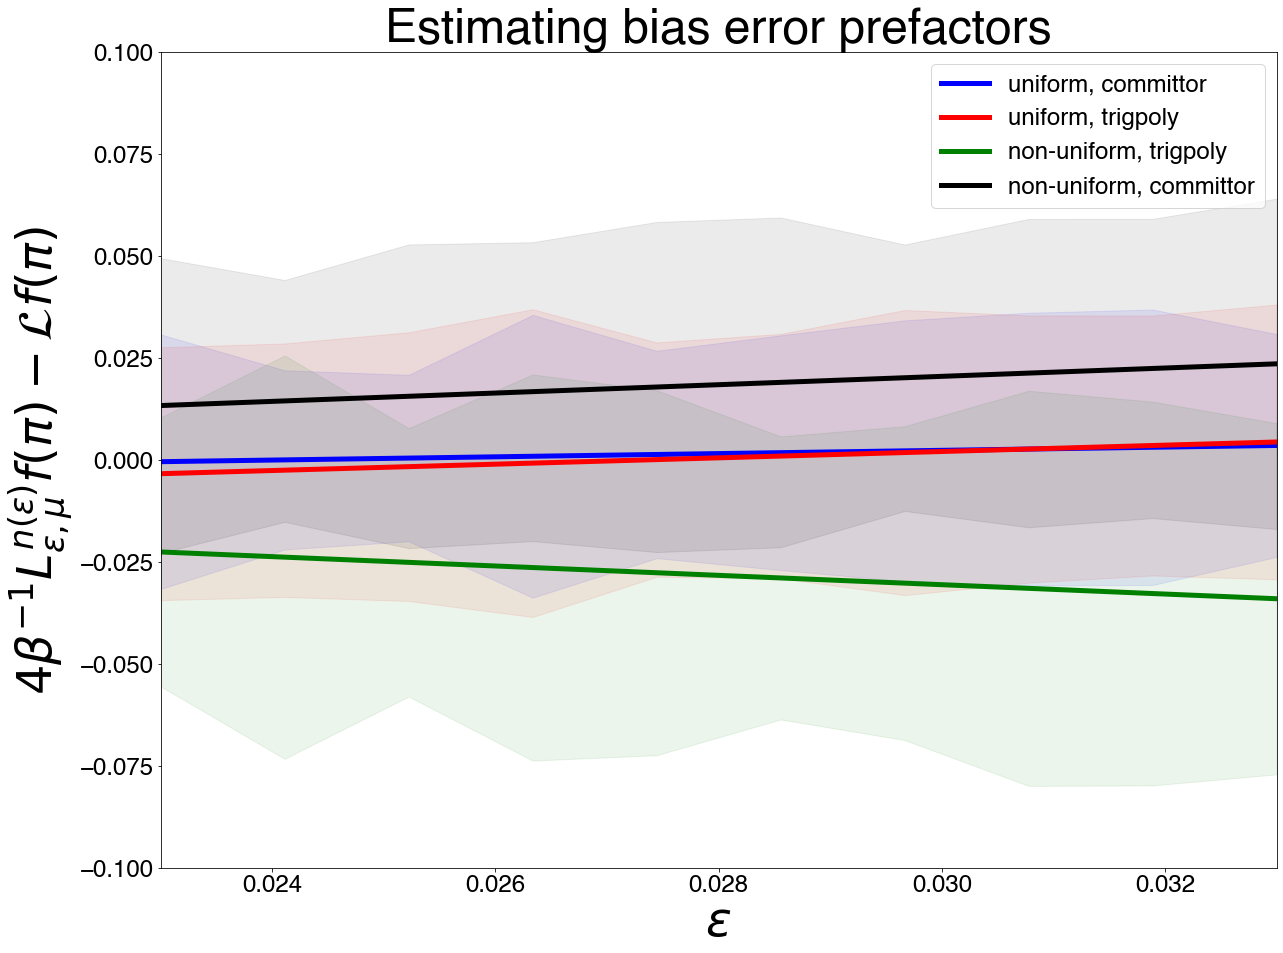

In [9]:
fig, ax = plt.subplots(figsize=(20,15))


for i in range(len(filestrings)):
    
    # get name of density + function 
    terms = filestrings[i].split('_')
    density = terms[0]
    function = terms[1]
    
    # run this for second gen dataset 
    data = np.load(filestrings[i], allow_pickle=True)
    epsilons = data.item()['epsilons']
    bias = data.item()['pointwise_errors']
    epsilons_range, ntrials = bias.shape
    
    # # fit linear model
    # x = epsilons.reshape((epsilons_range,1))@np.ones((1,ntrials))
    # linear_fit = sklearn.linear_model.LinearRegression()
    # linear_fit.fit(x.reshape(-1,1), bias.reshape(-1,1))
    # y = linear_fit.predict(epsilons.reshape(-1,1))
    
    # fit linear model
    beta_hat, sig_beta_hat = linear_reg(epsilons,bias)
    y = beta_hat[1]*epsilons + beta_hat[0]
    
    # get standard errors 
    RMSE = np.sqrt(np.mean((y.reshape((epsilons_range,1))@np.ones((1,ntrials)) - bias)**2, axis=1)).reshape(y.shape)
    y_low = y-RMSE
    y_high = y+RMSE
    
    # plot 
    if density == 'biased':
        density = 'non-uniform'
    
    ax.plot(epsilons,y,\
                 label=density+', '+function, 
                 # label=density+', '+function+", abs. prefactor= " + str(np.abs(round(linear_fit.coef_[0,0],5))),
                 # label=r'$\rho = $ ' + density + ', ' + r'$f = $ ' + function + ", abs. prefactor= " + str(np.abs(round(linear_fit.coef_[0,0],5))),
                 color=colors[i],
                 linewidth=5)
    ax.fill_between(epsilons,y_low.flatten(), y_high.flatten(), color = colors[i], alpha=0.08)

ax.set_xlim((epsilons[0], epsilons[-1]))
ax.set_ylim((-0.1,0.1))
ax.legend(loc = 'best')
ax.set_xlabel("$\epsilon$", fontsize=48)
ax.set_ylabel(r'$4\beta^{-1}L^{n(\epsilon)}_{\epsilon,\mu}f(\pi) - \mathcal{L} f(\pi)$', fontsize=48)
# ax.set(ylabel = r'$4\beta^{-1}L^{n(\epsilon)}_{\epsilon,\mu}f(0) - \mathcal{L} f(0)$', xlabel = "$\epsilon$", fontsize=48);
ax.set_title("Estimating bias error prefactors", fontsize=48)
fig.savefig("1d_bias_error_circular.pdf", bbox_inches="tight", format='pdf')